 Assignment: Create a customer segmentation
----------------------------------------------------

### Objective

The goal of this assignment is to segment a credit card customer base into different groups for marketing and customer management purposes.

### Dataset

Use the following dataset available on Kaggle:
1. Title – Customer Credit Card Data
2. Author  - n.a., Fatemeh Habibimoghaddam (Owner)
3. Source – https://www.kaggle.com/datasets/fhabibimoghaddam/customer-credit-card-data   
(alternatively, can be found in `DSIF-course-material/python-material/data/1-raw/dsif8-assignment`)
3. License – Attribution 4.0 International (CC BY 4.0)

### Instructions
-   **Load and Explore the Data:** Start by loading the data and performing basic exploratory data analysis (EDA).
-   **Data Preprocessing:** Handle missing values, standardize the data, and prepare it for clustering.
-   **Clustering:** Apply clustering techniques like K-Means or Hierarchical Clustering to segment the customers. Optionally, use PCA to reduce dimensionality before clustering.
-   **Segmentation and interpretation:** Create meaningful and valid customer segments (at least 2, pick the number that works best for you based on your analysis) that can be leveraged for targeted marketing, customer management, and strategic decision-making.

### Submission
Submit your Python code and a brief analysis using Markdown comments summarizing your findings and insights.

## Import libraries

In [238]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Import data

In [239]:
df = pd.read_csv("../data/1-raw/Customer_Data.csv")
df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONE_OFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONE_OFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


It would be a lot more convenient if we had a data dictionary but no such file was provided but we're data scientists so let's get creative!

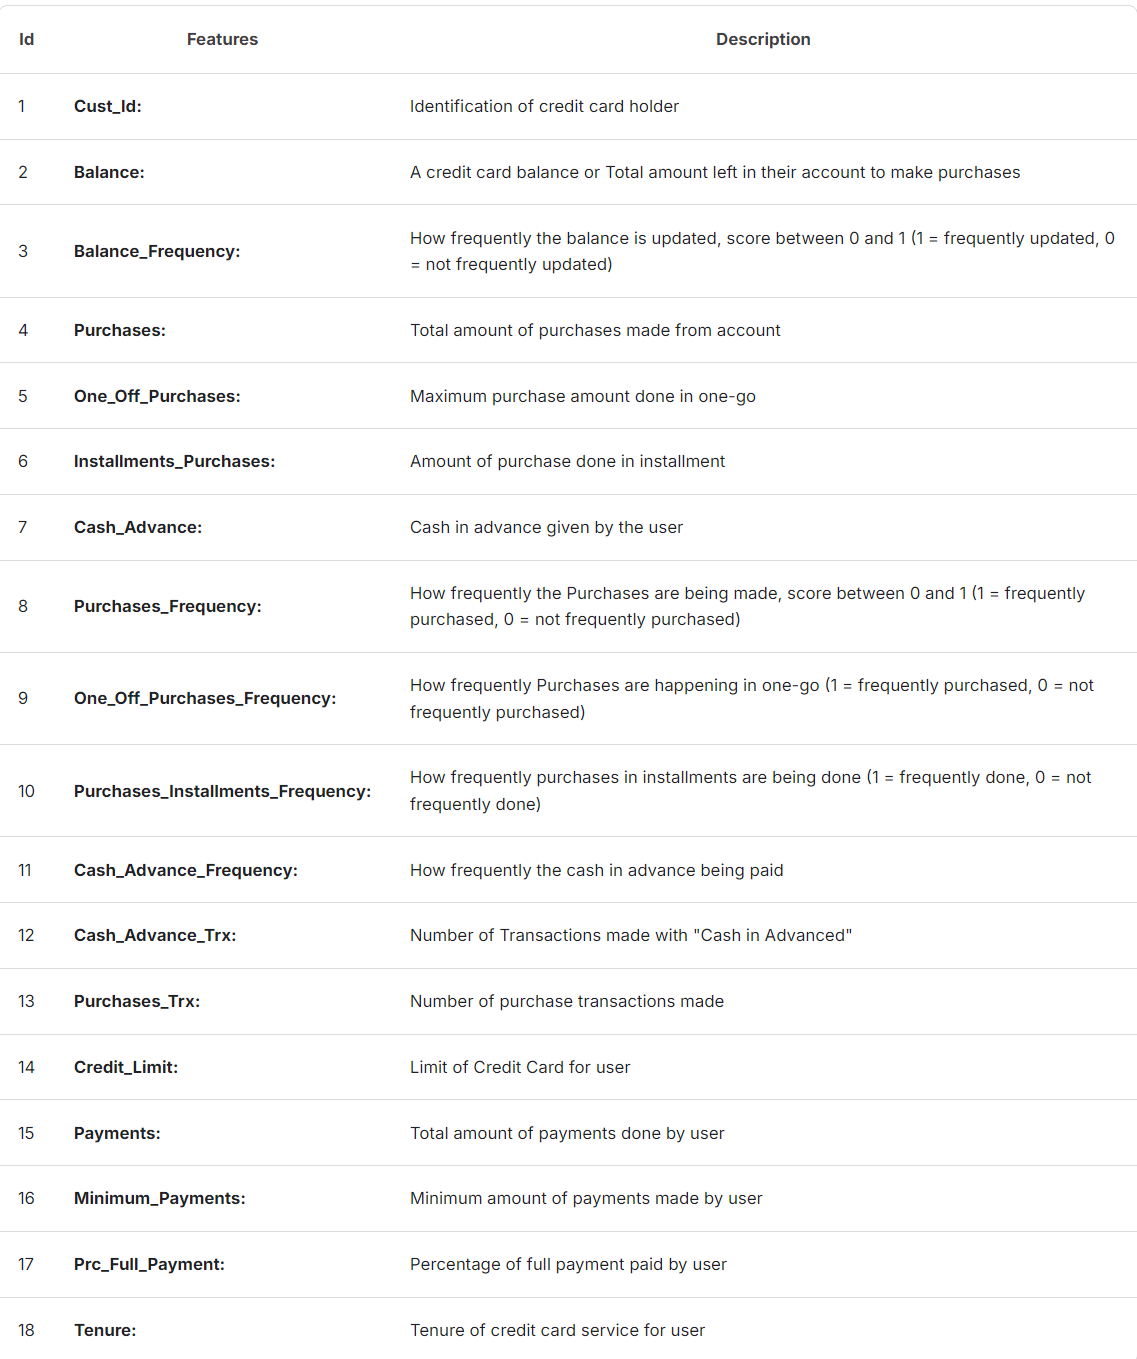

In [240]:
# Load in screenshot of data dictionary since there was no csv for it
Image(r'/mnt/c/Users/cheyd/Pictures/Screenshots/Screenshot 2024-10-16 221824.png')

## EDA (Exploratory Data Analysis) 

Let's become one with the data so we understand what we're dealing with and how to go about cleaning, preprocessing and essentially getting the data ready for clustering.

In [241]:
# Let's check for missing values, the data types present and the shape of our dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONE_OFF_PURCHASES                 8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONE_OFF_PURCHASES_FREQUENCY       8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [242]:
# Check number of missing values for MINIMUM_PAYMENTS just to avoid human error
df["MINIMUM_PAYMENTS"].isnull().sum()

313

- 18 features (columns)
- 8950 data points (rows)
- Object, float and int data types (1, 14, and 3 respectively)
- 1 missing value in `CREDIT_LIMIT` feature
- 313 missing values in `MINIMUM_PAYMENTS` feature

**Note:** Features are in all caps. That's not very pythonic. We might wanna change that to snake case.

In [243]:
# Let's change columns to snake case (I'm a true Pythonista)
df.columns = [column.lower() for column in df.columns]
print(df.columns)

Index(['cust_id', 'balance', 'balance_frequency', 'purchases',
       'one_off_purchases', 'installments_purchases', 'cash_advance',
       'purchases_frequency', 'one_off_purchases_frequency',
       'purchases_installments_frequency', 'cash_advance_frequency',
       'cash_advance_trx', 'purchases_trx', 'credit_limit', 'payments',
       'minimum_payments', 'prc_full_payment', 'tenure'],
      dtype='object')


Let's drop the `cust_id` column since it's irrelevant 

In [244]:
df_dropped = df.drop("cust_id", axis=1)
df_dropped.head()

,balance,balance_frequency,purchases,one_off_purchases,installments_purchases,cash_advance,purchases_frequency,one_off_purchases_frequency,purchases_installments_frequency,cash_advance_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [245]:
# Let's see some stats of our features now that they're all numeric
df_dropped.describe().T # transpose it to see features more clearly

,count,mean,std,min,25%,50%,75%,max
balance,8950.0,1564.474828,2081.531879,0.000000,128.281915,873.385231,2054.140036,19043.13856
balance_frequency,8950.0,0.877271,0.236904,0.000000,0.888889,1.000000,1.000000,1.00000
purchases,8950.0,1003.204834,2136.634782,0.000000,39.635000,361.280000,1110.130000,49039.57000
one_off_purchases,8950.0,592.437371,1659.887917,0.000000,0.000000,38.000000,577.405000,40761.25000
installments_purchases,8950.0,411.067645,904.338115,0.000000,0.000000,89.000000,468.637500,22500.00000
cash_advance,8950.0,978.871112,2097.163877,0.000000,0.000000,0.000000,1113.821139,47137.21176
purchases_frequency,8950.0,0.490351,0.401371,0.000000,0.083333,0.500000,0.916667,1.00000
one_off_purchases_frequency,8950.0,0.202458,0.298336,0.000000,0.000000,0.083333,0.300000,1.00000
purchases_installments_frequency,8950.0,0.364437,0.397448,0.000000,0.000000,0.166667,0.750000,1.00000
cash_advance_frequency,8950.0,0.135144,0.200121,0.000000,0.000000,0.000000,0.222222,1.50000


In [246]:
# Let's check for duplicates
df_dropped.duplicated().sum()

0

### Outlier detection

#### Using Z-score

In [247]:
# Calculate Z-scores for numerical columns
z_scores = np.abs(stats.zscore(df_dropped))

# Define a threshold for identifying outliers
threshold = 3

# How many outliers identified for each numerical columns?
gt_thresh = z_scores > threshold
outlier_volume = pd.DataFrame(gt_thresh.sum(), columns=["num_outliers"])
outlier_volume.sort_values(by = "num_outliers"
                          , ascending= False)

,num_outliers
tenure,394
cash_advance_frequency,199
balance,196
purchases_trx,185
cash_advance,182
balance_frequency,176
cash_advance_trx,172
payments,159
installments_purchases,137
purchases,135


Let's visualise the Z-score distribution for all the columns

In [248]:
# Create a function to plot the z-score distribution for all the columns
def plot_zscore_distribution(df):
    
    # Set up the figure for subplots
    num_columns = len(df.columns)
    fig, axes = plt.subplots(nrows=num_columns, ncols=1, figsize=(8, num_columns * 4))

    # Check if there's only one numeric column to avoid indexing issues
    if num_columns == 1:
        axes = [axes]

    # Loop through each numeric column
    for i, col in enumerate(df):
        # Calculate the z-scores for the current column
        z_scores = stats.zscore(df[col].dropna())  # Remove NaN values to avoid errors

        # Create the distribution plot on the respective subplot axis
        sns.histplot(z_scores, bins=10, ax=axes[i])

        # Set titles and labels
        axes[i].set_title(f'Z-score Distribution for {col}')
        axes[i].set_xlabel('Z-score')
        axes[i].set_ylabel('Frequency')

    # Automatically adjust the layout for readability
    plt.tight_layout()
    plt.show();

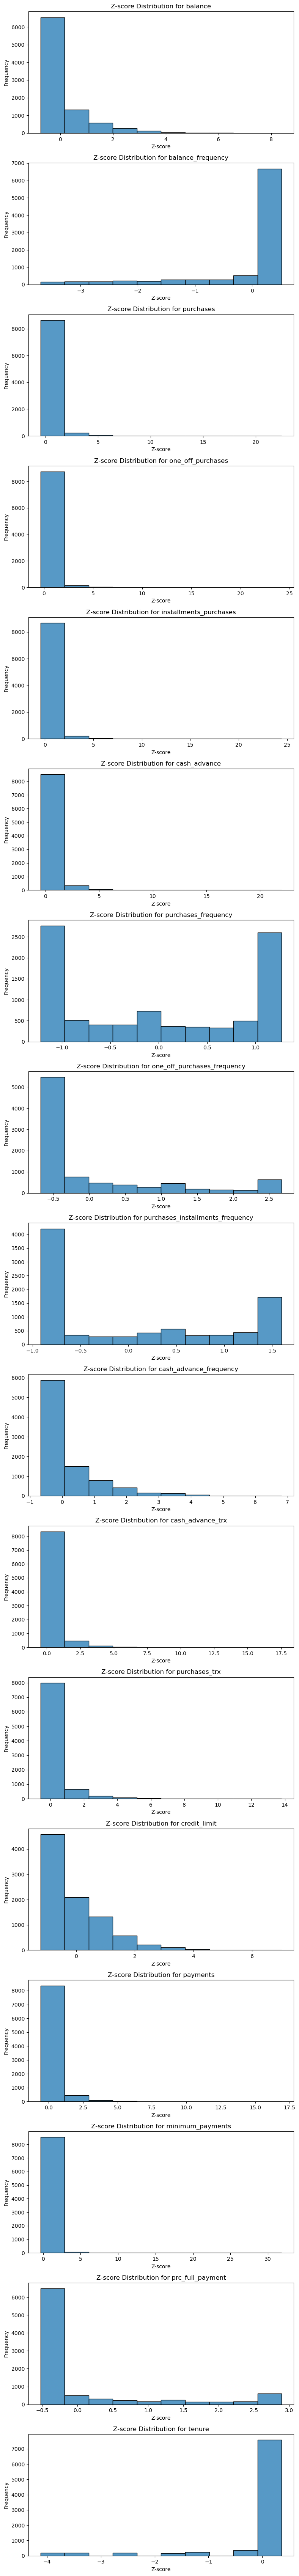

In [249]:
plot_zscore_distribution(df_dropped)

#### Using IQR

In [250]:
# Create a function to calculate the IQR for each column and create a boxplot to visualise the outliers
def identify_and_plot_outliers(df):
    """
    Identifies and plots outliers for each numerical column in the DataFrame using the IQR method.
    
    Parameters:
    - df: pandas DataFrame containing the data.

    This function will generate a series of boxplots, one for each numerical column, to help 
    visualize the outliers and decide on their validity. It also prints the number of outliers 
    for each column.
    """
    
    # Select numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Create subplots
    numeric_cols = [col for col in numeric_cols if df[col].nunique() > 1]  # Exclude constant columns
    num_plots = len(numeric_cols)
    
    # Determine the number of rows and columns for subplots
    n_rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, n_rows * 4))
    axes = axes.flatten()  # Flatten the 2D array of axes

    for i, col in enumerate(numeric_cols):
        # Calculate the IQR
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        
        # Define bounds for outliers
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        
        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        num_outliers = len(outliers)

        # Print the number of outliers
        print(f"{col}: {num_outliers} outliers found")
        
        # Plot boxplot
        axes[i].boxplot(df[col], vert=False)
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)
        
        # Highlight the outliers
        axes[i].scatter(outliers, np.ones_like(outliers) * 1, color='red', label='Outliers', alpha=0.5)

    # Hide any empty subplots
    for j in range(num_plots, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.legend()
    plt.show()


balance: 695 outliers found
balance_frequency: 1493 outliers found
purchases: 808 outliers found
one_off_purchases: 1013 outliers found
installments_purchases: 867 outliers found
cash_advance: 1030 outliers found
purchases_frequency: 0 outliers found
one_off_purchases_frequency: 782 outliers found
purchases_installments_frequency: 0 outliers found
cash_advance_frequency: 525 outliers found
cash_advance_trx: 804 outliers found
purchases_trx: 766 outliers found
credit_limit: 248 outliers found
payments: 808 outliers found
minimum_payments: 841 outliers found
prc_full_payment: 1474 outliers found
tenure: 1366 outliers found


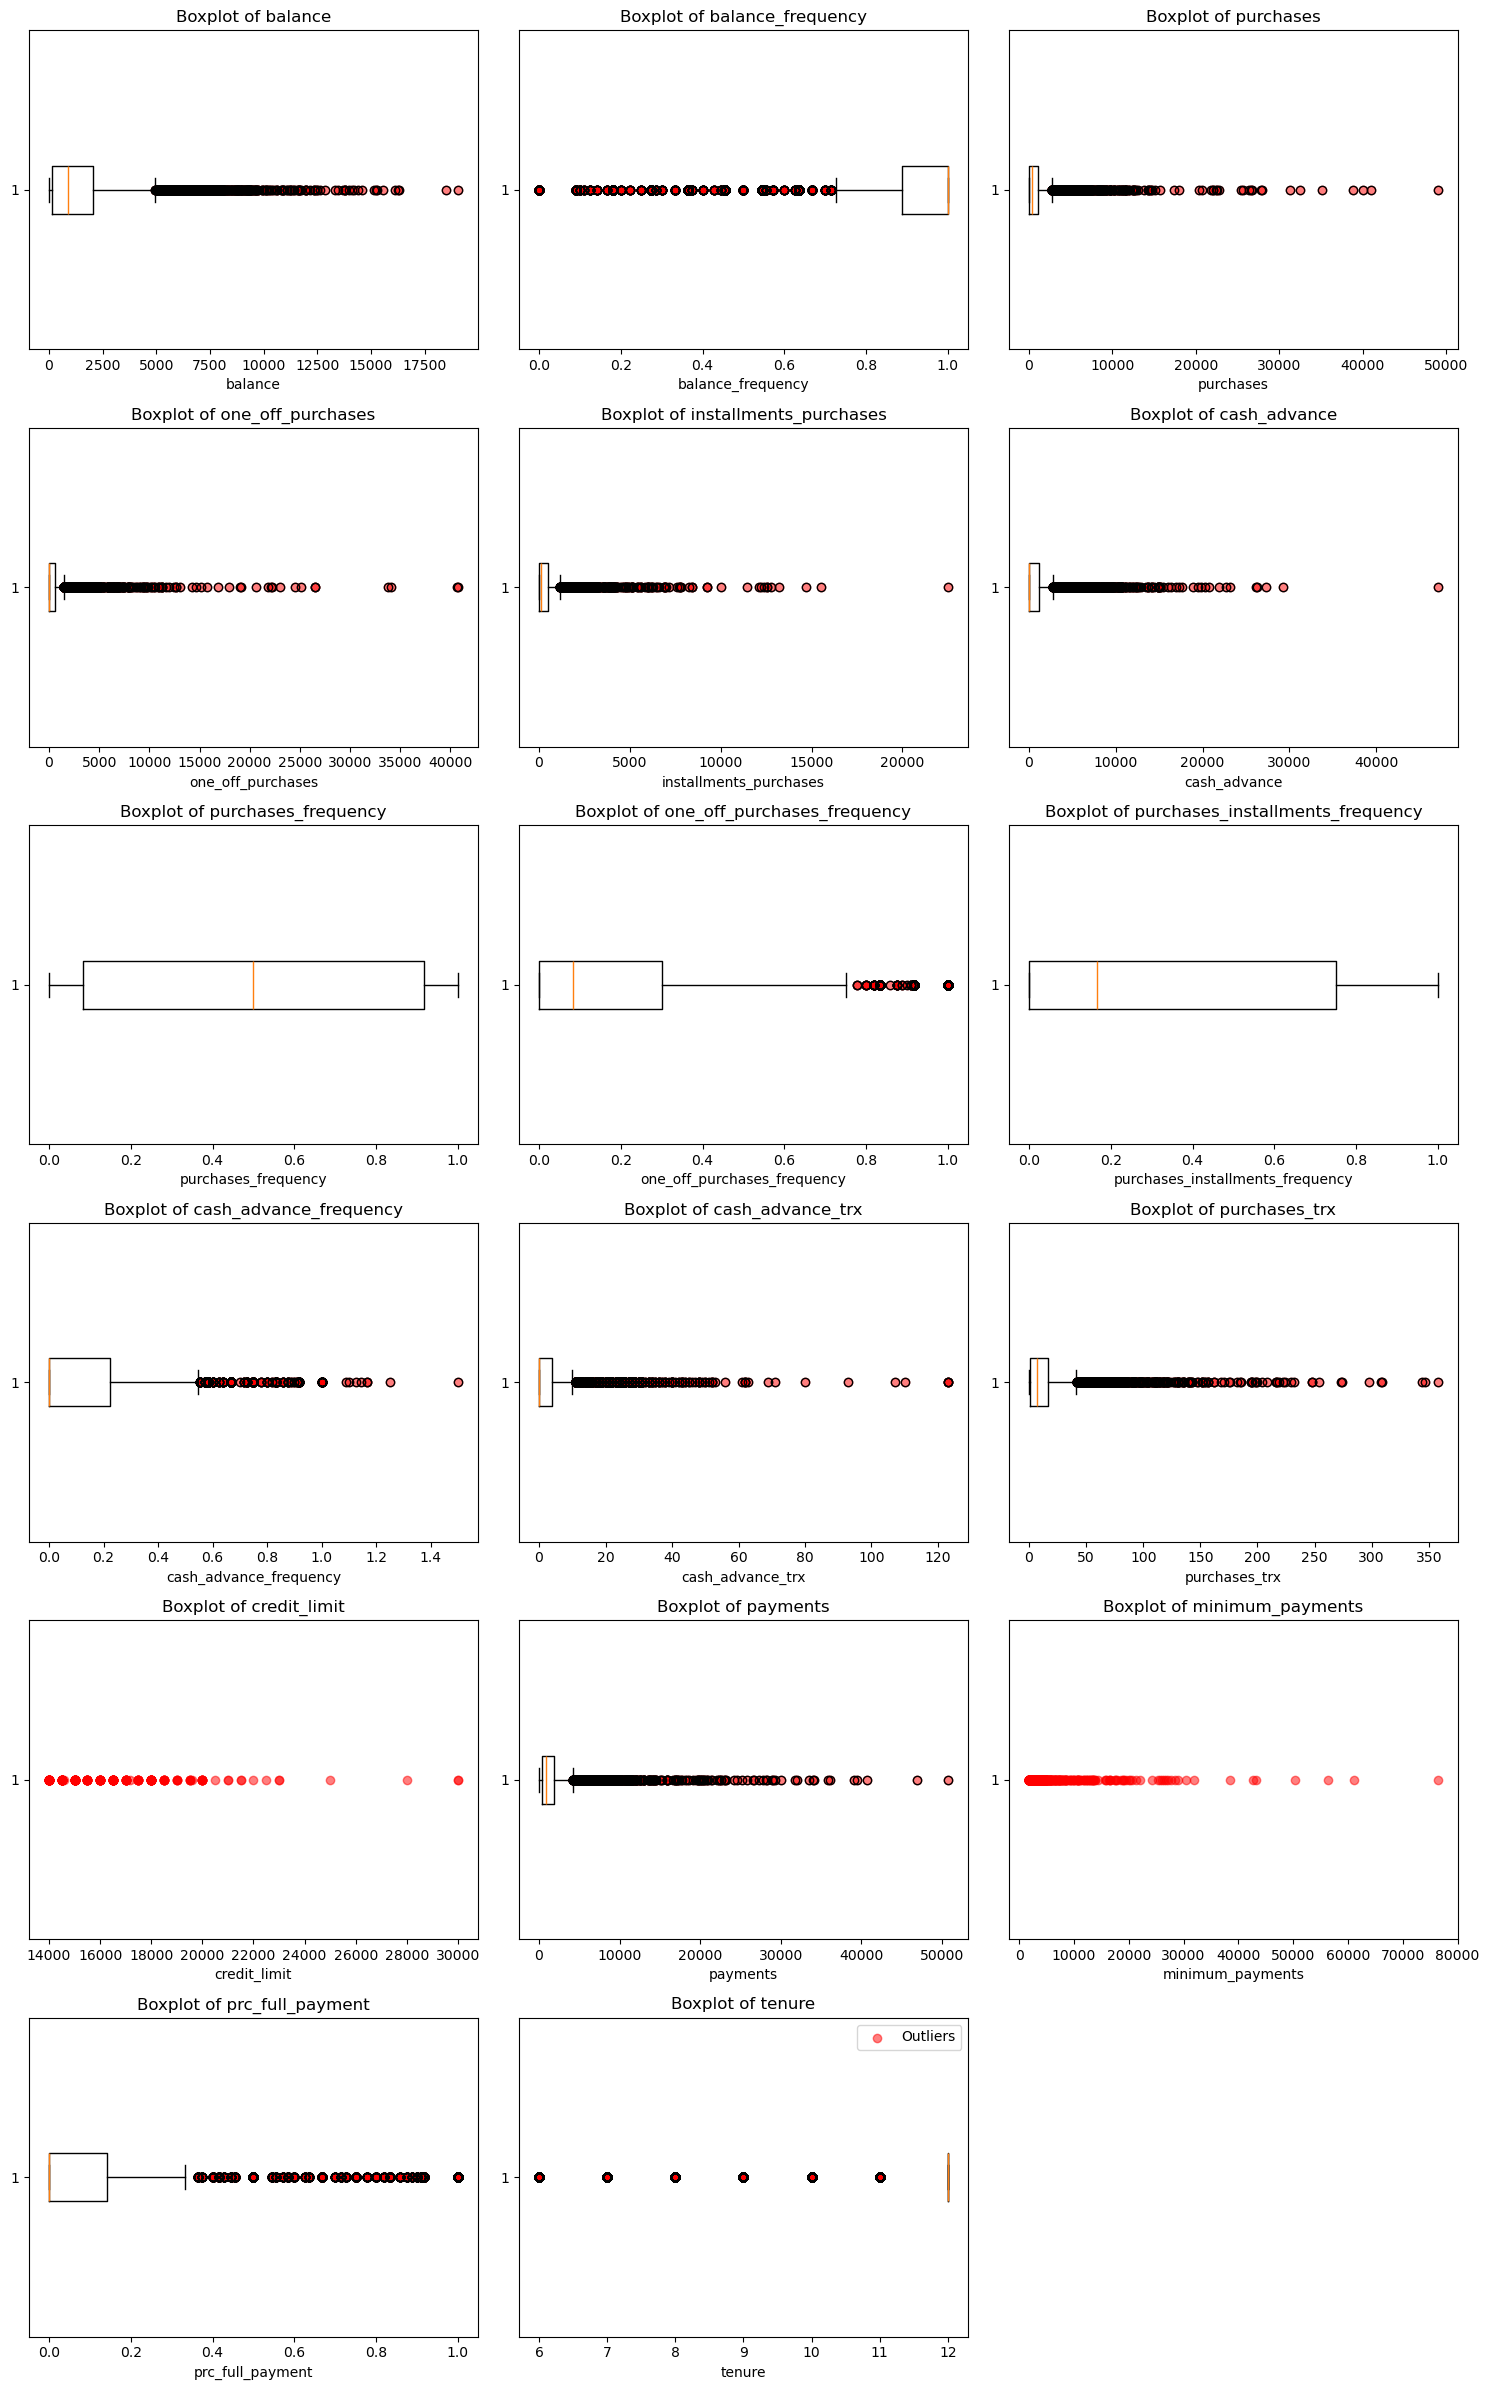

In [251]:
identify_and_plot_outliers(df_dropped)

It seems like it's better to use Z-score in this case as IQR is classifying to many data points as outliers.

Let's use the results from the Z-score to investigate some of the features with many outliers

In [252]:
df_dropped.tenure.value_counts()

tenure
12    7584
11     365
10     236
6      204
8      196
7      190
9      175
Name: count, dtype: int64

There doesn't seem to be any outliers in this feature. We can leave as is.

In [253]:
df_dropped["cash_advance_frequency"].describe()

count    8950.000000
mean        0.135144
std         0.200121
min         0.000000
25%         0.000000
50%         0.000000
75%         0.222222
max         1.500000
Name: cash_advance_frequency, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6cca80ac90>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6cca808a40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6cca809c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6cca8080e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6cca80ac00>],
 'means': []}

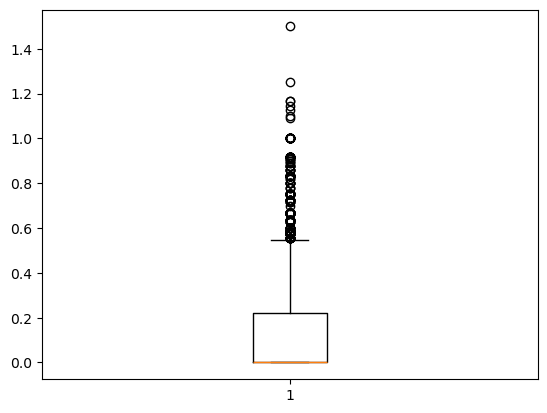

In [254]:
plt.boxplot(df_dropped["cash_advance_frequency"])

When we start cleaning and preprocessing the data we can handle outliers using standardisation.

### Correlation

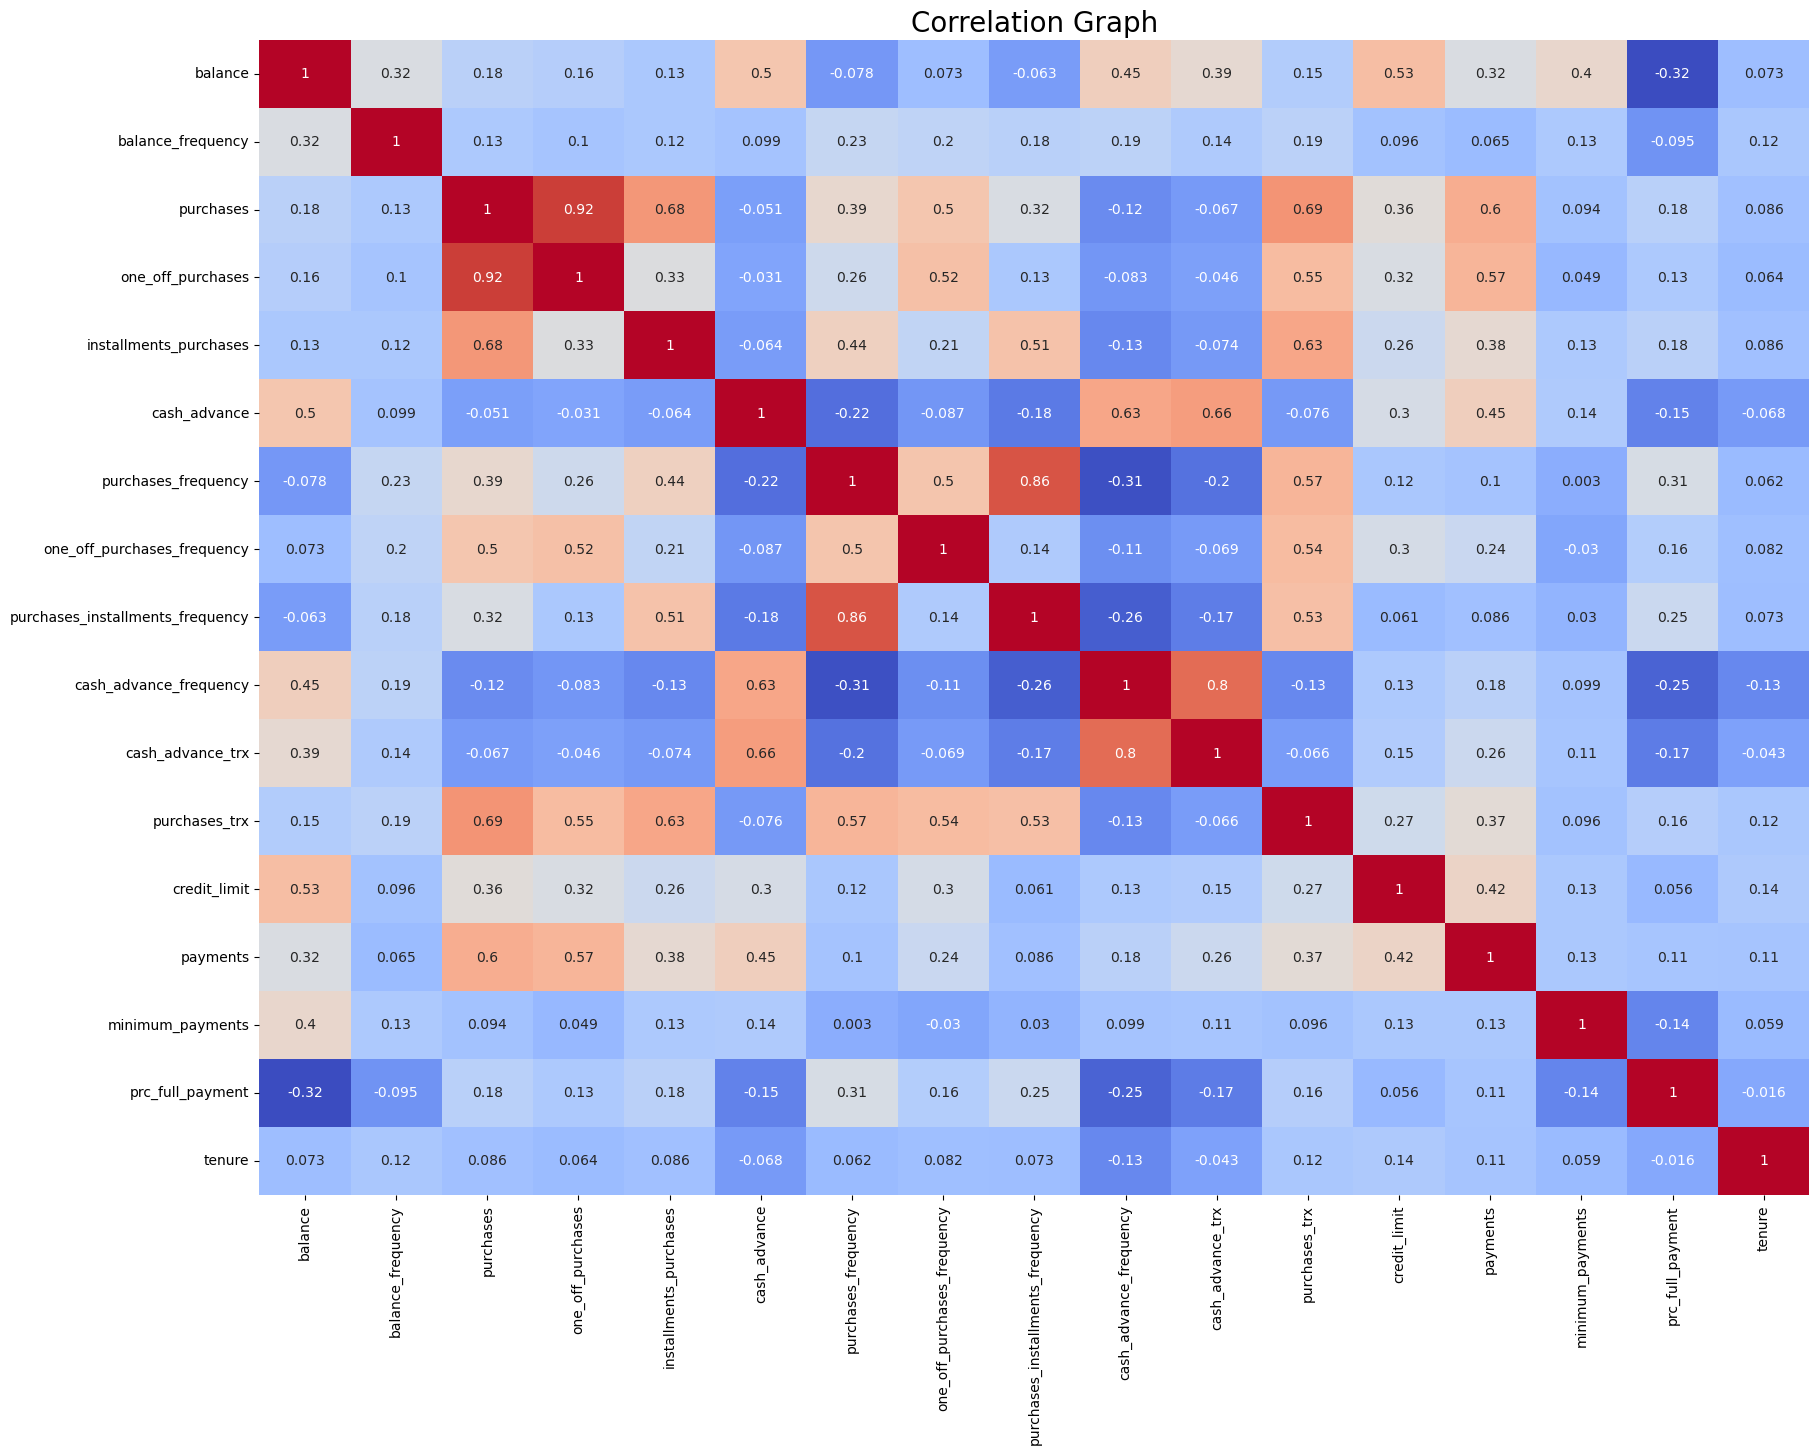

In [255]:
# let's create a correlation graph to visualise the correlation between the features
plt.figure(figsize = [20,15] ,  dpi = 100 )
plt.title("Correlation Graph" , fontsize = 20)
sns.heatmap(df_dropped.corr(), annot = True, cmap = 'coolwarm', cbar = False)
plt.show()

**Observations from Correlation Graph**
- `purchases` and `one_off_purcheses` have quite a high correlation (0.92)
- `purchases_installments_frequency` and `purchases_frequency` are also quite highly correlated (0.86)
- `cash_advance_trx` and `cash_advance_frequency` have the third highest correlation (0.8)

**Note:** We could potentially drop one feature from each pair since they have quite high correlation.

Let's visualise the correlations

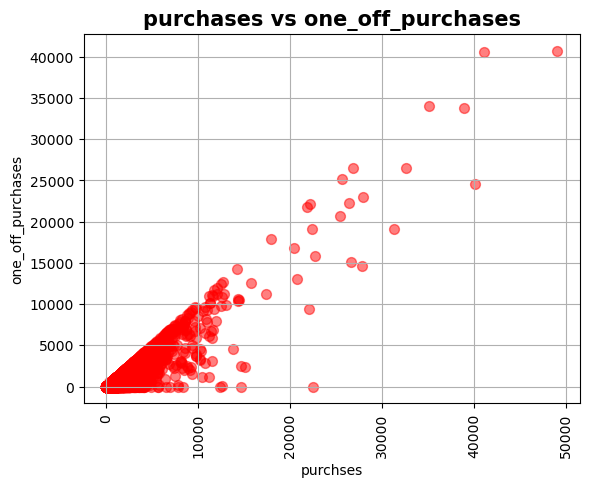

In [256]:
# Create scatter plot
plt.scatter(df_dropped["purchases"], df_dropped["one_off_purchases"], color="red", alpha=0.5, s=50)
plt.xticks(rotation=90)
plt.title("purchases vs one_off_purchases", weight="bold", color="black", fontsize=15)
plt.xlabel("purchses")
plt.ylabel("one_off_purchases")
plt.grid()
plt.show();

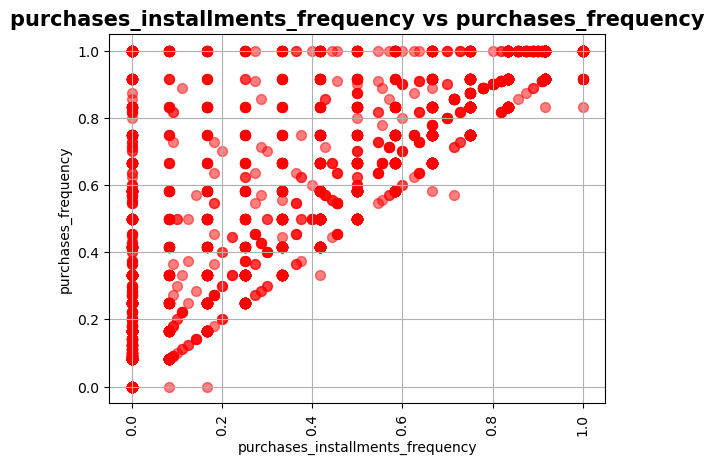

In [257]:
# Create scatter plot
plt.scatter(df_dropped["purchases_installments_frequency"], df_dropped["purchases_frequency"], color="red", alpha=0.5, s=50)
plt.xticks(rotation=90)
plt.title("purchases_installments_frequency vs purchases_frequency", weight="bold", color="black", fontsize=15)
plt.xlabel("purchases_installments_frequency")
plt.ylabel("purchases_frequency")
plt.grid()
plt.show();

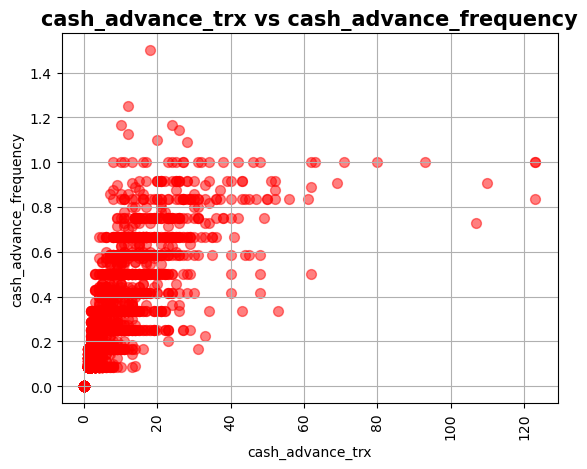

In [258]:
# Create scatter plot
plt.scatter(df_dropped["cash_advance_trx"], df_dropped["cash_advance_frequency"], color="red", alpha=0.5, s=50)
plt.xticks(rotation=90)
plt.title("cash_advance_trx vs cash_advance_frequency", weight="bold", color="black", fontsize=15)
plt.xlabel("cash_advance_trx")
plt.ylabel("cash_advance_frequency")
plt.grid()
plt.show();

#### Inference of Correlations

**`purchases` and `one_off_purcheses` (0.92)**
- Customers who spend more in total purchases are also likely to spend more on one-off purchases.
- The majority of the purchasing activity is through one-off purchases rather than installments. Customers prefer paying for their purchases in full at the time of purchase.

**`purchases_installments_frequency` and `purchases_frequency` (0.86)**
- Customers who purchase more frequently are also more likely to use installment payment options regularly.
- Frequent shoppers prefer to spread out their payments over time, possibly to manage their finances better or take advantage of credit options.

**`cash_advance_trx` and `cash_advance_frequency` (0.8)**
- Customers who frequently take cash advances tend to have a higher number of cash advance transactions.
- A segment of customers relies heavily on cash advances, possibly indicating short-term liquidity needs or financial stress.

## Data Preprocessing

Let's handle the missing values and standardize the data so that it's ready for clustering

In [259]:
# Let's look at the first 100 rows of these closely related featueres
df_dropped[["minimum_payments", "payments"]].head(100)

,minimum_payments,payments
0,139.509787,201.802084
1,1072.340217,4103.032597
2,627.284787,622.066742
3,NaN,0.000000
4,244.791237,678.334763
5,2407.246035,1400.057770
6,198.065894,6354.314328
7,532.033990,679.065082
8,311.963409,688.278568
9,100.302262,1164.770591


From the first 100 rows we can observe that quite a few of the rows with 0 in the `payments` column have "NaN" in `minimum_payments`.

Let's check how many rows there are with this 0-NaN pair. If there's a significant amount, it would make sense to replace the NaN's with 0 since if payments is 0 then there wouldn't be any minimum payment either i.e. 0.

In [260]:
len(df_dropped[(df_dropped["minimum_payments"].isna()) & (df_dropped["payments"] == 0)])

240

`minimum_payments` has 313 missing values. 240 of them correspond to 0 in the `payments` column.

Let's replace the 240 NaN values with a corresponding 0 in `payments` with a 0 and drop other 73 rows in `minimum_payments` and the 1 row in `credit_limit` with missing values.

In [261]:
# Replace NaN in 'minimum_payments' with 0 where 'payments' == 0
df_dropped.loc[(df_dropped["minimum_payments"].isna()) & (df_dropped["payments"] == 0), "minimum_payments"] = 0

In [262]:
# Let's check the first 100 rows again to see the transformation
df_dropped[["minimum_payments", "payments"]].head(100)

,minimum_payments,payments
0,139.509787,201.802084
1,1072.340217,4103.032597
2,627.284787,622.066742
3,0.000000,0.000000
4,244.791237,678.334763
5,2407.246035,1400.057770
6,198.065894,6354.314328
7,532.033990,679.065082
8,311.963409,688.278568
9,100.302262,1164.770591


Let's drop the remaining rows since they make up less then 1% of the data.

In [263]:
df_dropped_clean = df_dropped.dropna(subset=["minimum_payments", "credit_limit"])
len(df_dropped), len(df_dropped_clean)

(8950, 8876)

In [264]:
df_dropped_clean.isna().sum()

balance                             0
balance_frequency                   0
purchases                           0
one_off_purchases                   0
installments_purchases              0
cash_advance                        0
purchases_frequency                 0
one_off_purchases_frequency         0
purchases_installments_frequency    0
cash_advance_frequency              0
cash_advance_trx                    0
purchases_trx                       0
credit_limit                        0
payments                            0
minimum_payments                    0
prc_full_payment                    0
tenure                              0
dtype: int64

## Feature selection
Before we standardise our data, we should remove highly correlated features to reduce redundancy. 

Keeping only one feature from highly correlated pairs will simplify the clustering process and avoid overemphasizing any one feature.

**Note:** Since we'll be using PCA to reduce dimensionality, we don't necessarily have to remove the highly correlated features as PCA will handle that but we can at least remove the one out of the three highest correlated pairs above.

In [265]:
df_selected_features = df_dropped_clean.drop(["one_off_purchases", "purchases_frequency", "cash_advance_frequency"], axis=1)


### Standardisation

In [266]:
scaler = StandardScaler ()
scaled_features = scaler.fit_transform (df_selected_features)

In [267]:
scaled_features

array([[-0.73690461, -0.28776588, -0.42603954, ..., -0.29920062,
        -0.52834588,  0.35999505],
       [ 0.77930599,  0.11303679, -0.47053272, ...,  0.09870853,
         0.22915716,  0.35999505],
       [ 0.44009318,  0.51383946, -0.10993736, ..., -0.09113479,
        -0.52834588,  0.35999505],
       ...,
       [-0.74529818, -0.22096764, -0.40318664, ..., -0.32355359,
         0.32384589, -4.13201439],
       [-0.7500657 , -0.22096764, -0.47053272, ..., -0.33492688,
         0.32384589, -4.13201439],
       [-0.57777788, -0.95577033,  0.03934335, ..., -0.32104943,
        -0.52834588, -4.13201439]])

In [268]:
# Convert the scaled features back into a DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df_selected_features.columns)

## Clustering

Now that are data is cleaned and standardised. We can finally start clustering.
We'll carry out:
- PCA (Principal Component Analysis)
- KMeans Clustering
- Hierarchical Clustering


### PCA (Principal Component Analysis)

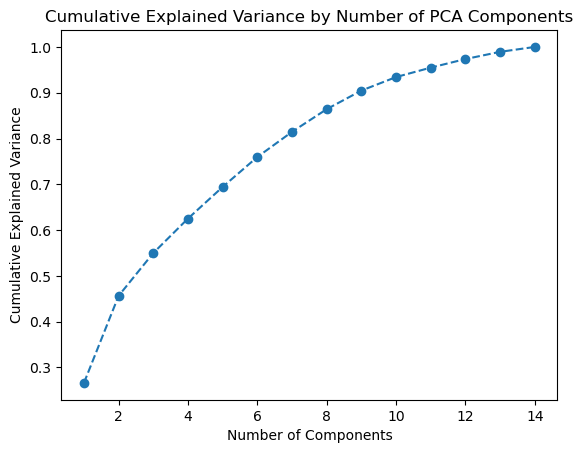

In [269]:
# Fit PCA and calculate explained variance
pca = PCA()
pca.fit(df_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Number of PCA Components')
plt.show()

Based on our graph, we can reasonably choose between 6-10 components.
- If we want to simplify the dataset as much as possible while still retaining important variance, we could go with around 6-8 components.
- If we want to retain a bit more variance and have room for a few more components, 10 components would capture over 90% of the variance.

We'll go with 8 as a happy medium.

In [270]:
# Select the number of components
pca = PCA(n_components=8)
pca = pca.fit_transform(df_scaled)

### KMeans Clustering

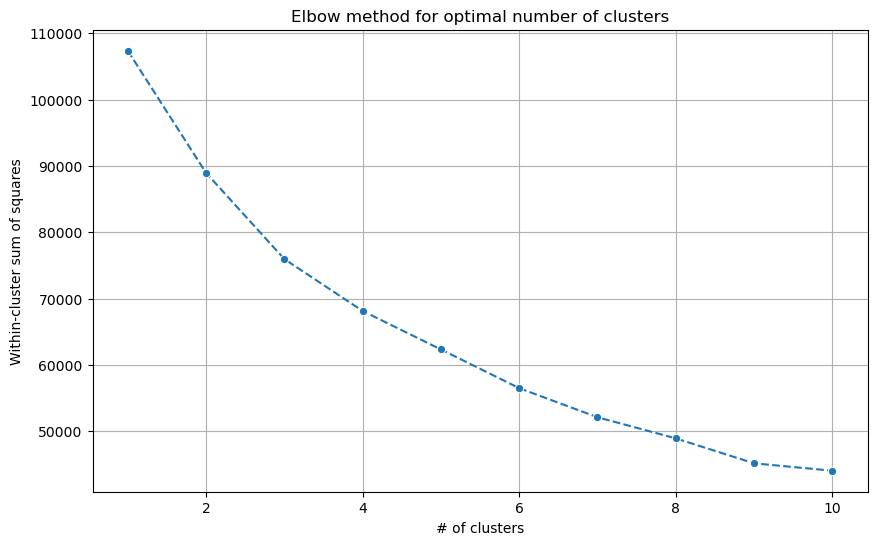

In [271]:
# Let's use the Elbow graph to determine optimal number of clusters:
wcss = []
max_clusters = 10

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(pca)
    wcss.append(kmeans.inertia_)

# Elbow Graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, max_clusters + 1), y=wcss, marker='o', linestyle='--')
plt.xlabel('# of clusters')
plt.ylabel('Within-cluster sum of squares')
plt.title('Elbow method for optimal number of clusters')
plt.grid(True)
plt.show();

Based on the above chart the elbow point seems to be around 3 and 4 clusters

In [272]:
num_clusters = 4

In [273]:
# Applying K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_scaled['cluster-km'] = kmeans.fit_predict(df_scaled)
df_scaled.head()

,balance,balance_frequency,purchases,installments_purchases,cash_advance,one_off_purchases_frequency,purchases_installments_frequency,cash_advance_trx,purchases_trx,credit_limit,payments,minimum_payments,prc_full_payment,tenure,cluster-km
0,-0.736905,-0.287766,-0.426040,-0.349910,-0.468992,-0.681576,-0.705852,-0.478306,-0.512413,-0.961640,-0.531938,-0.299201,-0.528346,0.359995,2
1,0.779306,0.113037,-0.470533,-0.455019,2.593303,-0.681576,-0.915619,0.105923,-0.592596,0.684124,0.820499,0.098709,0.229157,0.359995,0
2,0.440093,0.513839,-0.109937,-0.455019,-0.468992,2.662996,-0.915619,-0.478306,-0.111498,0.821271,-0.386245,-0.091135,-0.528346,0.359995,2
3,0.042775,-1.089371,0.228579,-0.455019,-0.371182,-0.402863,-0.915619,-0.332249,-0.552505,0.821271,-0.601897,-0.358710,-0.528346,0.359995,2
4,-0.364364,0.513839,-0.463071,-0.455019,-0.468992,-0.402863,-0.915619,-0.478306,-0.552505,-0.906781,-0.366739,-0.254292,-0.528346,0.359995,2


In [274]:
df_scaled["cluster-km"].value_counts()

cluster-km
2    4784
1    2042
3    1051
0     999
Name: count, dtype: int64

## Cluster Profiling
Now That we have our clusters let's analyse them to understand the characteristics of each segment.

We can do this through:
- descriptive statistics
- visualisations
- returning to the original data before scaling so that stakeholders can understand the segments and interpret them.

In [275]:
# Calculate the mean of each feature in non-scaled data by cluster
cluster_profile_actual = df_scaled.groupby('cluster-km').mean()
cluster_profile_actual.T

cluster-km,0,1,2,3
balance,1.719222,-0.693477,-0.130595,0.307654
balance_frequency,0.360773,-1.361779,0.408155,0.445028
purchases,-0.194518,-0.236132,-0.223033,1.658890
installments_purchases,-0.220200,-0.138227,-0.211896,1.442390
cash_advance,1.888163,-0.337085,-0.193243,-0.260202
one_off_purchases_frequency,-0.236529,-0.359133,-0.144118,1.578592
purchases_installments_frequency,-0.433392,-0.000668,-0.144421,1.070630
cash_advance_trx,1.589595,-0.366653,-0.119574,-0.254287
purchases_trx,-0.278045,-0.282879,-0.232284,1.871219
credit_limit,1.068563,-0.232481,-0.336483,0.967618


#### Visualisations

Let's visualise (univariate, bivariate, and multivariate) these segments to help our analysis and then make some interpretations and provide some insights/recommendations based on our findings.

**Univariate**

A boxplot for each cluster across key features helps us to visually compare the distributions of those features for each segment.

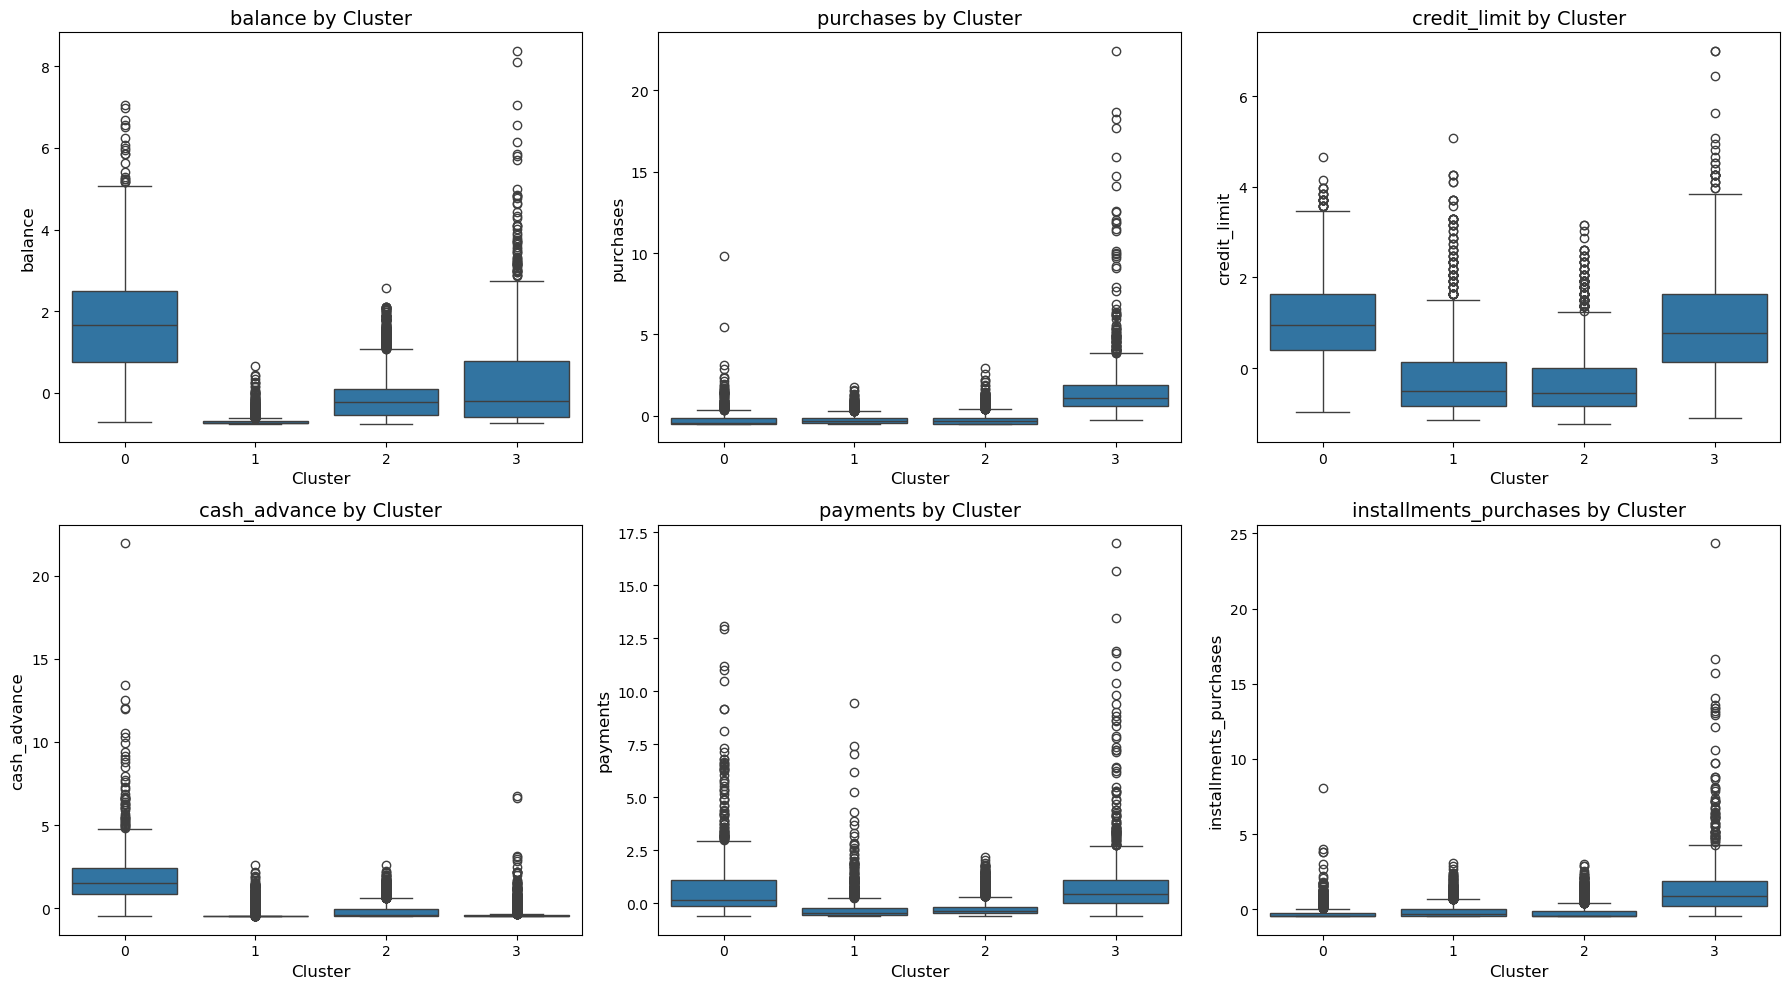

In [276]:
# Create a figure and axes for 6 subplots in a 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Define the features you want to plot
features = ['balance', 'purchases', 'credit_limit', 'cash_advance', 'payments', 'installments_purchases']

# Loop through each feature and create a boxplot in each subplot
for i, feature in enumerate(features):
    # Determine the current axis in the 2x3 grid
    ax = axes[i // 3, i % 3]  # Row is i//3 and column is i%3
    
    # Create the boxplot
    sns.boxplot(x='cluster-km', y=feature, data=df_scaled, ax=ax)
    
    # Set the title for each subplot
    ax.set_title(f'{feature} by Cluster', fontsize=14)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel(feature, fontsize=12)

# Adjust layout to avoid overlapping plots
plt.tight_layout()

# Show the plots
plt.show()


**Bivariate**

Scatter plots help us to see how two variables interact and how the clusters are distributed across those variables.

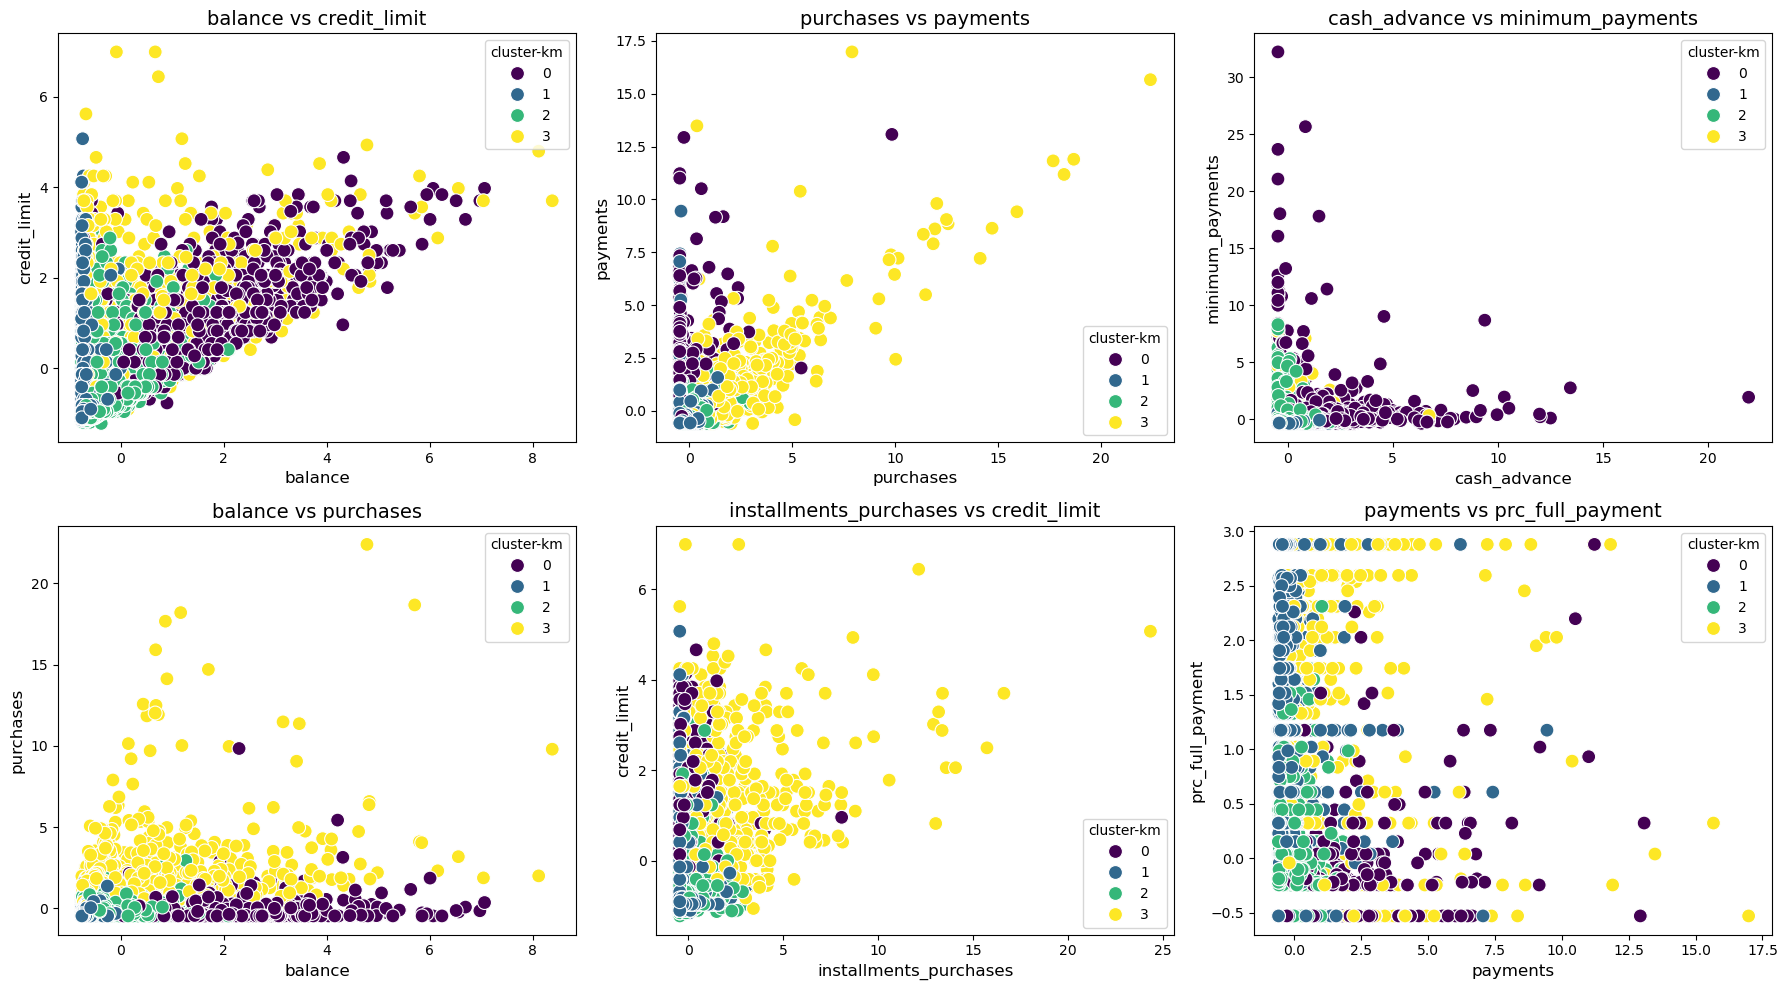

In [277]:
# Create a figure and axes for 6 subplots in a 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

# Define feature pairs to plot
feature_pairs = [
    ('balance', 'credit_limit'),       # Comparing balance and credit limit
    ('purchases', 'payments'),         # Comparing purchases and payments
    ('cash_advance', 'minimum_payments'),  # Comparing cash advance usage and minimum payments
    ('balance', 'purchases'),          # Comparing balance and purchases (spending vs debt)
    ('installments_purchases', 'credit_limit'),  # Comparing installment purchases and credit limit
    ('payments', 'prc_full_payment')   # Comparing payments and percentage of full payment
]

# Loop through each feature pair and create a scatter plot in each subplot
for i, (x_feature, y_feature) in enumerate(feature_pairs):
    # Determine the current axis in the 2x3 grid
    ax = axes[i // 3, i % 3]  # Row is i//3 and column is i%3
    
    # Create the scatterplot
    sns.scatterplot(data=df_scaled, x=x_feature, y=y_feature, hue='cluster-km', ax=ax, palette='viridis', s=100)
    
    # Set the title for each subplot
    ax.set_title(f'{x_feature} vs {y_feature}', fontsize=14)
    ax.set_xlabel(x_feature, fontsize=12)
    ax.set_ylabel(y_feature, fontsize=12)

# Adjust layout to avoid overlapping plots
plt.tight_layout()

# Show the plots
plt.show();

**Multivariate**

A heatmap of the mean values for each feature across the clusters provides an overall picture of how each feature contributes to the cluster profiles.

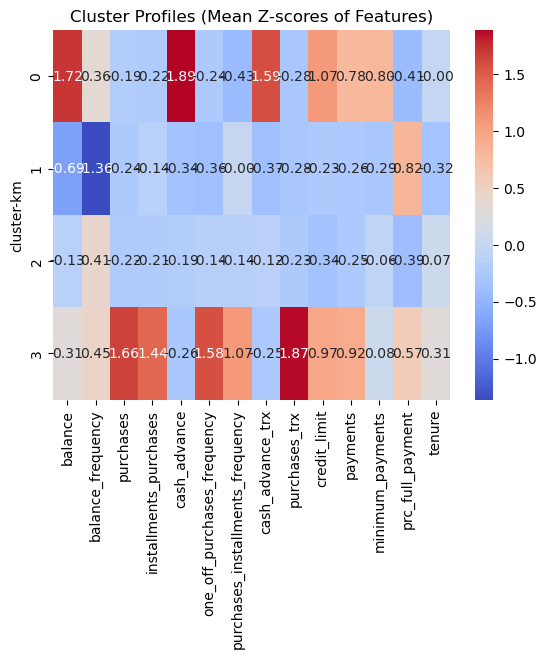

In [278]:
sns.heatmap(cluster_profile_actual, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cluster Profiles (Mean Z-scores of Features)')
plt.show();

## Visualisation-Based Findings:

**Boxplots**:

Clear differentiation in balance, cash advance usage, and installment purchases between clusters, showing unique financial behaviors per segment.
For instance, Cluster 0 exhibits very high balances, while Cluster 3 shows significant purchase activity.

**Scatterplots**:

Relationships between key financial variables are evident:
Balance vs Credit Limit: Clusters 0 and 3 have high balances and credit limits, but Cluster 3 shows better balance management (lower reliance on cash advances).
Purchases vs Payments: High-purchasing Cluster 3 makes high payments, but the scatter suggests they don't fully pay their balances, leaving room for promoting installment plans.

**Heatmap of Cluster Profiles**:

The heatmap shows clear z-score profiles across clusters, with Cluster 0 exhibiting high balances and reliance on cash advances, while Cluster 3 leads in purchases and payments.
These profiles can guide the design of personalized products and targeted campaigns based on each segment's behavior.

## Customer Segmentation Analysis and Insights for Targeted Marketing and Strategic Decision-Making

This analysis is based on the customer segmentation results derived from the KMeans clustering algorithm. The dataset was reduced using PCA, and clustering was performed based on key financial behaviors of customers, such as balance, purchases, payments, and credit limit. Four distinct customer clusters were identified, and their behaviors across several key features were visualized through boxplots, scatterplots, and a heatmap of cluster profiles.

### Cluster Overview

#### 1. **Cluster 0 (High Balance, Cash-Advance Users)**
   
- Balance: This cluster has very high balances (mean z-score = 1.72), significantly higher than the other clusters.
- Cash Advances: They rely heavily on cash advances (z-score = 1.89), which indicates financial stress or a need for liquidity.
- Credit Limit: They have a high credit limit (z-score = 1.07), but their usage patterns suggest they are maxing out their available credit.
- Minimum Payments: Higher than average minimum payments (z-score = 0.79), suggesting they might only be paying the minimum amount due on their credit cards.
- Purchases: Slightly below average purchases (z-score = -0.19), meaning they don’t use their credit cards heavily for purchases, instead relying on cash advances.

**Actionable Insights for Cluster 0:**

- Targeted Offers: Provide this segment with debt consolidation or low-interest personal loan offers to help manage their high balances and reduce reliance on high-interest cash advances.
- Financial Education: Offer credit management counseling or programs that encourage reducing balance levels and paying more than the minimum.
- Credit Limit Management: Consider reviewing their credit limit usage to ensure they're not consistently maxing out their cards. Proactive credit limit adjustment notifications may help these customers manage their credit more responsibly.

#### 2. **Cluster 1 (Low Balance, Financially Conservative)**
   
- Balance: This group has below-average balances (z-score = -0.69).
- Purchases: Slightly below-average purchase activity (z-score = -0.24).
- Cash Advances: They use very little to no cash advances (z-score = -0.34).
- Credit Limit: Their credit limits are also below average (z-score = -0.23).
- Payments: They consistently pay off their balances (high percentage of full payments z-score = 0.82), indicating they manage their credit responsibly.

**Actionable Insights for Cluster 1:**
- Loyalty and Rewards: Focus on rewards-based incentives to encourage this group to spend more, such as cashback offers or travel rewards for increased credit usage.
- Upsell Higher Credit Products: Offer this segment higher credit limits or premium credit cards that provide better rewards, given their responsible usage.
- Engagement Programs: Design campaigns to encourage more frequent spending, such as seasonal promotions or limited-time discounts to boost their relatively low purchase behavior.

#### 3. **Cluster 2 (Moderate Users, Low Activity)**
   
- Balance: Balances close to the average (z-score = -0.13), indicating a balanced credit usage.
- Purchases: Slightly below-average purchase behavior (z-score = -0.22).
- Cash Advances: Minimal use of cash advances (z-score = -0.19).
- Payments: Below-average payment activity (z-score = -0.25), meaning they may not be as engaged with their credit card usage.
- Credit Limit: This segment has below-average credit limits (z-score = -0.34).

**Actionable Insights for Cluster 2:**
- Engagement Campaigns: Focus on re-engagement strategies by offering exclusive deals or discounts to encourage more frequent spending.
- Installment Plans: Introduce installment payment options to help drive higher-value purchases, especially for those who might be hesitant to spend larger amounts at once.
- Educational Offers: Offer credit education programs to help them understand the benefits of responsible credit usage, and encourage higher credit engagement.

#### 4. **Cluster 3 (High Purchasers, Responsible Credit Users)**
   
- Purchases: This group is characterized by very high purchases (z-score = 1.66), making them a key revenue driver.
- Credit Limit: Their credit limit is above average (z-score = 0.97), giving them more financial flexibility.
- Payments: High payments (z-score = 0.92) indicate they are making substantial payments toward their balance, but they likely don't pay in full.
- Installment Purchases: They frequently use installment purchases (z-score = 1.44), indicating a strategic use of credit for large purchases.
- Percentage Full Payment: They make a higher-than-average portion of full payments (z-score = 0.57), showing responsible credit use.

**Actionable Insights for Cluster 3:**
- Premium Rewards: Offer premium loyalty programs or exclusive VIP perks such as priority customer service or early access to sales to retain this high-value group.
- Installment Plan Marketing: Promote installment payment programs or low-interest installment offers to encourage more spending on larger purchases.
- Higher Credit Products: Upsell them to higher credit limit products or premium credit cards, as they are likely to take advantage of enhanced credit features.


## Overall Strategic Recommendations:
- Debt Management Programs for Cluster 0:
                          
- Focus on creating financial products that cater to individuals with high balances and reliance on cash advances. Introducing low-interest loans or consolidation products could improve customer satisfaction and retention.
Rewards-Based Spending Incentives for Cluster 1:

- Given their conservative financial behavior, create incentives such as reward points, cashback, or travel benefits that encourage increased spending without increasing financial risk.
Re-Engagement Campaigns for Cluster 2:

- Consider personalized marketing campaigns aimed at re-engaging this group through seasonal promotions, exclusive discounts, and installment purchase offers to drive higher engagement and loyalty.
Premium Services and Retention Strategies for Cluster 3:

- These are high-value customers with responsible credit habits. Retention strategies should focus on personalized offers, premium credit products, and loyalty programs that enhance their credit card experience and drive further purchases.